# Conv-TasNet

## 動作確認

In [1]:
%run conv_tasnet.py

入力(B, T) : torch.Size([2, 32000])
出力(B, N, T) : torch.Size([2, 1, 32000])


## 必要なライブラリ

In [2]:
import wave
import IPython.display
import os
import time
import torch
import glob
import tqdm
import transformers
import conv_tasnet

import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from utility import models, sdr
from scipy.io.wavfile import write
from scipy import signal

## 前処理

### 必要な関数の定義

In [2]:
def adjust_length(wav, length):
    add_length = length - len(wav)
    add = np.zeros(add_length, dtype = 'float32')
    return np.concatenate([wav, add], axis = 0)

### 音声波形の長さを閾値に収める. (wav_down_16000 : 16000 < length < 84000, noisy_del を作るとき一度だけ実行)

In [30]:
# noisy_del = sorted(glob.glob('/home/nakaya-shunsuke/noise_sound_wav_down_16000_del/*.wav'))
# # target_del = sorted(glob.glob('/home/nakaya-shunsuke/wav_down_16000_del/*.wav'))
# for i, wav in enumerate(noisy_del):
#     l = wave.open(wav, 'r').getnframes()
#     if l < 16000 or l > 84000:
#         os.remove(noisy_del[i])
#         # os.remove(target_del[i])

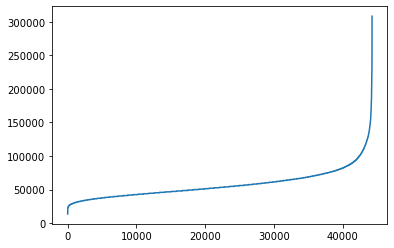

In [76]:
# noisy = sorted(glob.glob('/home/nakaya-shunsuke/noisy_wav_down_16000/*.wav'))
# lengths = [wave.open(n, 'r').getnframes() for n in noisy]
# x = np.arange(0, len(lengths), 1)
# plt.plot(x, sorted(lengths))

### 音声波形の長さを閾値に収める. (wav_down_8000 : 8000 < length < 32000, noisy_del を作るとき一度だけ実行)

In [8]:
# noisy_del = sorted(glob.glob('/home/nakaya-shunsuke/noisy_wav_down_8000_del/*.wav'))
# target_del = sorted(glob.glob('/home/nakaya-shunsuke/wav_down_8000_del/*.wav'))
# for i, wav in enumerate(noisy_del):
#     l = wave.open(wav, 'r').getnframes()
#     if l < 8000 or l > 32000:
#         os.remove(noisy_del[i])
#         os.remove(target_del[i])

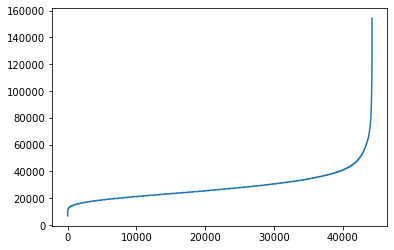

In [10]:
# noisy = sorted(glob.glob('/home/nakaya-shunsuke/noisy_wav_down_8000/*.wav'))
# lengths = [wave.open(n, 'r').getnframes() for n in noisy]
# x = np.arange(0, len(lengths), 1)
# plt.plot(x, sorted(lengths))

### 音声波形の長さを合わせる. (wav_dow16000 : length_max = 84000) 
-> DataLoader の方で合わせることにしたので不要.

In [13]:
# data_size = 10000
# lengths = [wave.open(n, 'r').getnframes() for n in noisy]
# noisy_waves = []
# target_waves = []
# max_length = max(lengths)
# for k, (n, t) in enumerate(zip(noisy[:data_size], target[:data_size])):
#     if k%5000 == 0:
#         print(str(k) + ' files written.')
        
#     noisy_file = wave.open(n, 'r')
#     x_noisy = noisy_file.readframes(lengths[k])
#     noisy_wav = np.frombuffer(x_noisy, dtype = 'int16')

#     noisy_waves.append(adjust_length(noisy_wav, max_length))
#     noisy_file.close()
    
#     target_file = wave.open(t, 'r')
#     x_target = target_file.readframes(lengths[k])
#     target_wav = np.frombuffer(x_target, dtype = 'int16')
#     target_waves.append(adjust_length(target_wav, max_length))
#     target_file.close()
    
# print('End, ' + str(k + 1) + ' files written.')

0 files written.
5000 files written.
End, 10000 files written.


### 音声波形のリストを作成

### サンプリングレート16000Hz の場合.

In [3]:
noisy = sorted(glob.glob('/home/nakaya-shunsuke/noisy_wav_down_16000_del/*.wav'))
target = sorted(glob.glob('/home/nakaya-shunsuke/wav_down_16000_del/*.wav'))

assert len(noisy) == len(target), 'different size of input and output.'

print('{0} data exist.'.format(len(noisy)))

40370 data exist.


In [4]:
IPython.display.Audio(target[0], rate = 16000)

### サンプリングレート8000Hz の場合.

In [5]:
# noisy = sorted(glob.glob('/home/nakaya-shunsuke/noisy_wav_down_8000_del/*.wav'))
# target = sorted(glob.glob('/home/nakaya-shunsuke/wav_down_8000_del/*.wav'))

# assert len(noisy) == len(target), 'different size of input and output.'

# print('{0} data exist.'.format(len(noisy)))

31856 data exist.


### データを train, valid に分割

In [5]:
data_size = 40370
x_train = []
x_valid = []
y_train = []
y_valid = []

for k, (n, t) in tqdm.tqdm(enumerate(zip(noisy[:data_size], target[:data_size]))):
    if k%5000 == 0:
        print(f'{k} files written.')
        
    # 入力データの作成
    noisy_file = wave.open(n, 'r')
    x_noisy = noisy_file.readframes(noisy_file.getnframes())
    noisy_wav = np.frombuffer(x_noisy, dtype = 'int16')
    if k%10 == 0:
        x_valid.append(noisy_wav)
    else:
        x_train.append(noisy_wav)
    noisy_file.close()

    # 正解データの作成
    target_file = wave.open(t, 'r')
    x_target = target_file.readframes(target_file.getnframes())
    target_wav = np.frombuffer(x_target, dtype = 'int16')
    # 入力データ作成時の wav の割合に合わせる
    target_wav = ((1 + k%3)*target_wav) / (2 + k%3)
    if k%10 == 0:
        y_valid.append(target_wav)
    else:
        y_train.append(target_wav)
    target_file.close()

print(f'End, {k + 1} files written.')
print('Data size : ')
print('x_train = {0}, y_train = {1}'.format(len(x_train), len(y_train)))
print('x_valid = {0}, y_valid = {1}'.format(len(x_valid), len(y_valid)))

445it [00:00, 2251.92it/s]

0 files written.


5325it [00:01, 2835.58it/s]

5000 files written.


10418it [00:03, 2762.83it/s]

10000 files written.


15456it [00:05, 2757.73it/s]

15000 files written.


20320it [00:07, 2675.30it/s]

20000 files written.


25446it [00:09, 2545.66it/s]

25000 files written.


30524it [00:11, 2695.19it/s]

30000 files written.


35634it [00:12, 3026.47it/s]

35000 files written.


40370it [00:14, 2764.16it/s]

40000 files written.
End, 40370 files written.
Data size : 
x_train = 36333, y_train = 36333
x_valid = 4037, y_valid = 4037


In [6]:
samples = 0
sample_rate = 16000
for data in x_train + x_valid:
    samples += len(data)
print('{1} samples, {2} seconds, {0:.4} GB'.format(64*samples/(8*1000*1000*1000), samples, samples//sample_rate))

2121005653 samples, 132562 seconds, 16.97 GB


### データの保存

In [6]:
# x_train = np.array(x_train)
# x_valid = np.array(x_valid)
# y_train = np.array(y_train)
# y_valid = np.array(y_valid)

In [7]:
# np.save('/home/nakaya-shunsuke/saved_waves/x_train_16000.npy', x_train)
# np.save('/home/nakaya-shunsuke/saved_waves/y_train_16000.npy', y_train)
# np.save('/home/nakaya-shunsuke/saved_waves/x_valid_16000.npy', x_valid)
# np.save('/home/nakaya-shunsuke/saved_waves/y_valid_16000.npy', y_valid)

### データのロード

In [8]:
# x_train = np.load('/home/nakaya-shunsuke/saved_waves/x_train_16000.npy')
# y_train = np.load('/home/nakaya-shunsuke/saved_waves/y_train_16000.npy')
# x_valid = np.load('/home/nakaya-shunsuke/saved_waves/x_valid_16000.npy')
# y_valid = np.load('/home/nakaya-shunsuke/saved_waves/y_valid_16000.npy')

## 学習に用いるデータセットの用意

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class AudioDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # 入力
        self.Y = Y # 出力

    def __len__(self):
        return len(self.X) # データ数を返す

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        # return (torch.tensor(self.X[index]).to(device), 
        #         torch.tensor(self.Y[index]).to(device))
        return (torch.tensor(self.X[index]), 
                torch.tensor(self.Y[index]))

In [9]:
train_dataset = AudioDataset(x_train, y_train)
valid_dataset = AudioDataset(x_valid, y_valid)

## 学習

### 学習に用いる関数

In [10]:
def collate_fn_adjust_length(batch_data):
    max_length = np.max([len(data_x) for (data_x, data_y) in batch_data])
    tensors_x = []
    tensors_y = []
    for (data_x, data_y) in batch_data:
        add_length = max_length - len(data_x)
        add_data = torch.zeros(add_length)
        tensors_x.append(torch.cat([data_x, add_data], 0))
        tensors_y.append(torch.cat([data_y, add_data], 0))
    tensors_x_out = torch.stack(tensors_x, dim = 0)
    tensors_y_out = torch.stack(tensors_y, dim = 0)
    return (tensors_x_out, tensors_y_out)

In [11]:
def train_valid_model(train_dataset, valid_dataset, batch_size, model, loss, optimizer, num_epochs, model_dir):
    loss_train_list = []
    loss_valid_list = []
    lrs = []
    best_loss_valid = np.inf
    count = 0
    
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn_adjust_length) #colate_fn でバッチごとの大きさ
    valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False, collate_fn = collate_fn_adjust_length)
    # scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, (len(train_dataset)//batch_size)*2, (len(train_dataset)//batch_size)*num_epochs)
    # scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, (len(train_dataset)//batch_size)*2, (len(train_dataset)//batch_size)*num_epochs, 3)

    # training
    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        loss_train = 0
        total = 0
        for i, (X, Y) in tqdm.tqdm(enumerate(train_dataloader)):
            X = X.to(device)
            Y = Y.to(device)
            out = model(X)
            Y = Y.unsqueeze(1)
            batch_loss = -loss(out, Y)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            lrs.append(np.log10(optimizer.param_groups[0]["lr"]))
            # scheduler.step()
            
            loss_train += batch_loss.item()
            total += 1
            
        loss_train = loss_train / total
        loss_train_list.append(loss_train)
        end = time.time()
           
        
        # validation
        model.eval()
        loss_valid = 0
        total = 0
        with torch.no_grad():
            for i, (X, Y) in enumerate(valid_dataloader):
                X = X.to(device)
                Y = Y.to(device)
                pred = model(X)
                Y = Y.unsqueeze(1)
                batch_loss = -loss(pred, Y)
                
                loss_valid += batch_loss.item()
                total += 1
                
            loss_valid = loss_valid / total
            loss_valid_list.append(loss_valid)
            
            # save parameter
            torch.save(model.state_dict(), f'./{model_dir}/last.pth')
            if epoch != 0 and epoch%10 == 0:
                torch.save(model.state_dict(), f'./{model_dir}/epoch_{epoch}.pth')
                
            if loss_valid <= best_loss_valid:
                torch.save(model.state_dict(), f'./{model_dir}/best.pth')
                best_loss_valid = loss_valid
                count = 0
            
            else:
                count += 1
                # 3連続 loss が減少しない場合に lr *= 0.5
                if count == 3:
                    optimizer.param_groups[0]['lr'] *= 0.5
                    print('Learning rate is halved, now lr = {0}'.format(optimizer.param_groups[0]['lr']))
                    count = 0
        
        print(f'epoch:{epoch} training_time:{end - start} \n train_loss:{loss_train} valid_loss:{loss_valid}')
        
    plt.plot(lrs)
    plt.show()

In [12]:
# 重み初期化用関数
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.normal_(m.weight.data, 0.0, 0.0075)
    elif isinstance(m, nn.GroupNorm):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### モデルの定義

In [13]:
tasnet = conv_tasnet.TasNet()
tasnet.apply(weights_init)
tasnet.to(device)
print('')
# print(tas_net)

### ハイパーパラメータ

In [14]:
num_epochs = 100
batch_size = 4
criterion = sdr.batch_SDR_torch
lr = 1e-3 # 0.0001
opt = torch.optim.Adam(tasnet.parameters(), lr = lr)

### 学習と評価

In [ ]:
train_valid_model(train_dataset, valid_dataset, batch_size, tasnet, criterion, opt, num_epochs, 'env_noise_model_path')

9084it [41:55,  3.61it/s]


epoch:0 training_time:2515.145960330963 
 train_loss:19.634257567408344 valid_loss:17.03682443425797


9084it [42:09,  3.59it/s]


epoch:1 training_time:2529.892343521118 
 train_loss:18.90903726417468 valid_loss:15.08024953475388


9084it [42:21,  3.57it/s]


epoch:2 training_time:2541.759301662445 
 train_loss:18.328160424962416 valid_loss:14.236238179776338


9084it [42:35,  3.55it/s]


epoch:3 training_time:2555.7537190914154 
 train_loss:17.30707292028595 valid_loss:13.019704052905487


9084it [42:24,  3.57it/s]


epoch:4 training_time:2544.560562610626 
 train_loss:17.405809099094977 valid_loss:13.698058657735439


9084it [42:24,  3.57it/s]


epoch:5 training_time:2544.3718078136444 
 train_loss:17.301178547407314 valid_loss:13.26851655738336


9084it [42:33,  3.56it/s]


Learning rate is halved, now lr = 0.0005
epoch:6 training_time:2553.7769565582275 
 train_loss:17.212415181605603 valid_loss:13.561883349532243


9084it [42:10,  3.59it/s]


epoch:7 training_time:2530.912888288498 
 train_loss:17.25440522329492 valid_loss:13.015410741898092


9084it [42:02,  3.60it/s]


epoch:8 training_time:2522.2926347255707 
 train_loss:16.81986039477548 valid_loss:12.587389726892557


9084it [42:02,  3.60it/s]


epoch:9 training_time:2522.5619320869446 
 train_loss:16.58147993218728 valid_loss:12.60019653578206


9084it [41:55,  3.61it/s]


epoch:10 training_time:2515.4102840423584 
 train_loss:16.59069121503921 valid_loss:12.659490924136769


9084it [41:59,  3.61it/s]


epoch:11 training_time:2519.4224891662598 
 train_loss:16.590385295229236 valid_loss:12.578739363545239


9084it [42:20,  3.58it/s]


epoch:12 training_time:2540.373057603836 
 train_loss:16.643139974033286 valid_loss:12.531062271158294


9084it [42:04,  3.60it/s]


epoch:13 training_time:2524.3519015312195 
 train_loss:16.511947558710915 valid_loss:12.451337304716874


9084it [42:01,  3.60it/s]


epoch:14 training_time:2521.0447487831116 
 train_loss:16.50115733847058 valid_loss:12.492823944218678


9084it [42:22,  3.57it/s]


epoch:15 training_time:2542.990963459015 
 train_loss:16.516935328383347 valid_loss:12.65388017813168


9084it [42:10,  3.59it/s]


Learning rate is halved, now lr = 0.00025
epoch:16 training_time:2530.093290567398 
 train_loss:16.49378537720636 valid_loss:12.478043980547918


9084it [42:09,  3.59it/s]


epoch:17 training_time:2529.206862449646 
 train_loss:16.49470792158836 valid_loss:12.477325944816418


9084it [42:24,  3.57it/s]


epoch:18 training_time:2544.5895528793335 
 train_loss:16.413435568547477 valid_loss:12.422552376115085


9084it [41:56,  3.61it/s]


epoch:19 training_time:2516.836420059204 
 train_loss:16.33551546025288 valid_loss:12.353258282167486


9084it [42:08,  3.59it/s]


epoch:20 training_time:2528.8097093105316 
 train_loss:16.328349883223172 valid_loss:12.477599147449036


9084it [42:07,  3.59it/s]


epoch:21 training_time:2527.9611768722534 
 train_loss:16.383222290882713 valid_loss:12.408830099545494


9084it [42:10,  3.59it/s]


Learning rate is halved, now lr = 0.000125
epoch:22 training_time:2530.6363101005554 
 train_loss:16.297420678102547 valid_loss:12.365675757058186


9084it [42:14,  3.58it/s]


epoch:23 training_time:2534.4380419254303 
 train_loss:16.24208074319043 valid_loss:12.315944854612694


9084it [42:11,  3.59it/s]


epoch:24 training_time:2531.501842737198 
 train_loss:16.225277988505454 valid_loss:12.297718823553607


9084it [42:15,  3.58it/s]


epoch:25 training_time:2535.6122901439667 
 train_loss:16.220341296286662 valid_loss:12.29359817265874


9084it [42:12,  3.59it/s]


epoch:26 training_time:2532.857339143753 
 train_loss:16.222031183342335 valid_loss:12.296471674895228


9084it [42:06,  3.59it/s]


epoch:27 training_time:2526.9963965415955 
 train_loss:16.185144626236518 valid_loss:12.273891853489499


9084it [42:12,  3.59it/s]


epoch:28 training_time:2532.7725694179535 
 train_loss:16.196490987713762 valid_loss:12.210068538659575


9084it [42:07,  3.59it/s]


epoch:29 training_time:2527.2679913043976 
 train_loss:16.17742068045012 valid_loss:12.256244446329847


9084it [42:06,  3.59it/s]


epoch:30 training_time:2526.910478115082 
 train_loss:16.176994500498036 valid_loss:12.185777333253386


9084it [42:18,  3.58it/s]


epoch:31 training_time:2538.4874675273895 
 train_loss:16.155282433483077 valid_loss:12.24231225123795


9084it [42:07,  3.59it/s]


epoch:32 training_time:2527.326473236084 
 train_loss:16.154144198424994 valid_loss:12.18756381293187


9084it [42:12,  3.59it/s]


Learning rate is halved, now lr = 6.25e-05
epoch:33 training_time:2532.072534799576 
 train_loss:16.134628599959058 valid_loss:12.209779814719269


9084it [41:56,  3.61it/s]


epoch:34 training_time:2516.1453864574432 
 train_loss:16.137692538247936 valid_loss:12.150285458063134


9084it [42:09,  3.59it/s]


epoch:35 training_time:2529.7229375839233 
 train_loss:16.131859307084273 valid_loss:12.144460217831748


9084it [42:00,  3.60it/s]


epoch:36 training_time:2520.7960550785065 
 train_loss:16.115150391973494 valid_loss:12.15004883504445


9084it [42:06,  3.59it/s]


epoch:37 training_time:2526.90518450737 
 train_loss:16.08658057997083 valid_loss:12.136168383755306


9084it [42:07,  3.59it/s]


epoch:38 training_time:2527.3709065914154 
 train_loss:16.083895671170307 valid_loss:12.13204705468794


9084it [42:19,  3.58it/s]


epoch:39 training_time:2539.424041748047 
 train_loss:16.07116692909542 valid_loss:12.128384399886178


4512it [20:49,  3.70it/s]

## モデルの出力を音声に変換

### 学習済モデルのパラメータをロード

In [33]:
tasnet = conv_tasnet.TasNet()
tasnet.to(device)
print('')
tasnet.load_state_dict(torch.load('./env_noise_model_path/last.pth', map_location = device))

<All keys matched successfully>

In [44]:
num_valid = 100
x_wav, y_wav = valid_dataset[num_valid]
x_wav = x_wav.unsqueeze(0).to(torch.float32)
x_wav = x_wav.to(device)
output = tasnet(x_wav)

In [46]:
# tensor to numpy
output_np = output[0][0].to('cpu').detach().numpy().copy()
output_np = output_np.astype(np.int16)

### 出力音声

In [47]:
IPython.display.Audio(output_np, rate = sample_rate)

### 入力音声

In [42]:
IPython.display.Audio(x_valid[num_valid], rate = sample_rate)

### target 音声

In [43]:
IPython.display.Audio(y_valid[num_valid], rate = samples_rate)

### (入力 - 出力)音声

In [48]:
IPython.display.Audio(x_valid[num_valid] - output_np, rate = 16000)

ValueError: operands could not be broadcast together with shapes (38931,) (32824,) 